In [20]:
import matplotlib.pyplot as plt
import numpy as np
import os, os.path
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import yfinance as yf
from datetime import date, timedelta
from statsmodels.regression.rolling import RollingOLS

from etl.yfinance_data import get_pairs_data
from performance.performance_metrics import percentage_returns, sharpe_ratio
from performance.risk_free_rate import compute_risk_free_rate


sns.set_style("darkgrid")

# Data

Tickers:

    Futures:
    - "NG=F": natural gas front month
    - "CL=F": WTI crude oil front month
    - "BZ=F": Brent crude oil front month
    
    ETFs:
    - BNO: Brent crude (c. front month)
    - USO: WTI (c. front month)


Notes:
- Commodities futures & ETFs not currently beating buy and hold.
- 1d, days=365, end_date=2022-10-26, ticker1-"IVW", ticker2="SPY", lookback=60. Good.

In [21]:
today = date.today()
end_date = today.strftime("%Y-%m-%d")

interval = "1h"

interval_map = {
    "1m": timedelta(minutes=60*24*7),
    "1h": timedelta(hours=24*90),
    "1d": timedelta(days=365*1),   
}

start_date = (today - interval_map[interval]).strftime("%Y-%m-%d")
print(start_date, end_date)

ticker1 = "BZ=F"
ticker2 = "CL=F"
df = get_pairs_data(ticker1, ticker2, start_date, end_date, interval)
df.tail()

2022-08-06 2022-11-04
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,S1,S2
2022-11-02 19:00:00-04:00,95.290001,88.980003
2022-11-02 20:00:00-04:00,95.309998,89.040001
2022-11-02 21:00:00-04:00,95.690002,89.370003
2022-11-02 22:00:00-04:00,95.849998,89.510002
2022-11-02 23:00:00-04:00,95.800003,89.529999


# Plots to assess relationships in raw data

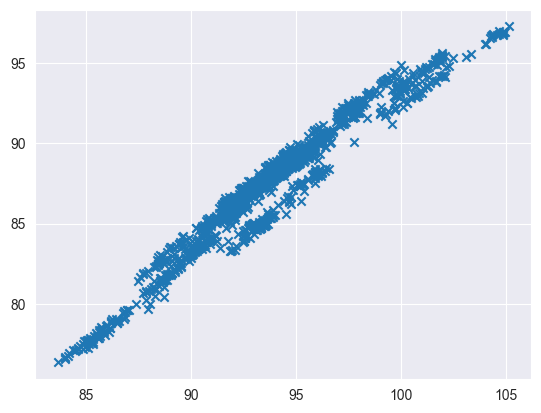

In [22]:
# Assess linearity
plt.scatter(df["S1"], df["S2"], marker="x")
plt.show()

# Model Fitting
https://www.statsmodels.org/dev/generated/statsmodels.regression.rolling.RollingOLS.html

In [23]:
# Prepend a column of 1.0s to the df for y.
# y = sm.add_constant(df[f"close_{ticker2}"])

# Prepend a column of 1.0s to the df for X.
X = sm.add_constant(df["S2"])

# Dependent variable.
y = df["S1"]

# Number of periods to lookback for the rolling linear regression.
# Note: this number of periods in the output results -> NaN.
lookback_periods = 60
# lookback_periods = 100

# model = RollingOLS(endog=X, exog=y, window=lookback_periods)
model = RollingOLS(endog=y, exog=X, window=lookback_periods)

residuals = model.fit()
parameters = residuals.params.copy()

<AxesSubplot: >

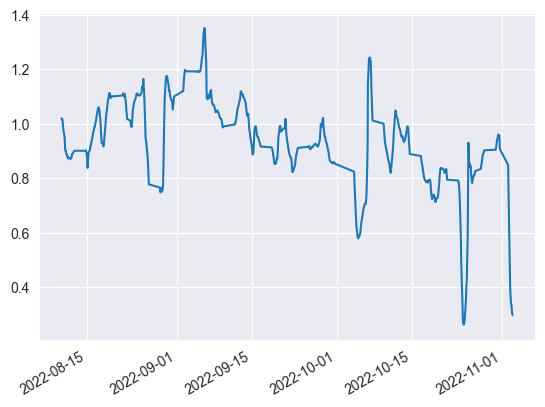

In [24]:
# Hedging Ratio between pairs
df["hedge_ratio"] = parameters["S2"]

# Drop the NaNs introduced by the lookback period
df.dropna(inplace=True)

df["hedge_ratio"].plot()

In [25]:
# Testing
# df["hedge_ratio"] = 0.0
# df["hedge_ratio"] = 1.0
# df["hedge_ratio"].plot()

# Plots to assess relationships in processed proposed portfolio

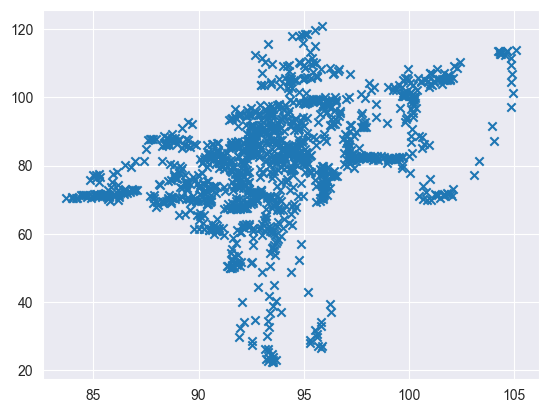

In [26]:
plt.scatter(df["S1"], df["hedge_ratio"] * df["S2"], marker="x")
plt.show()

# Feature Creation

In [27]:
# Spread
df["spread"] = df["S1"] - df["hedge_ratio"] * df["S2"]

# Compute Z-score of the spread -> entry/exit signals.
df["zscore"] = (df["spread"] - df["spread"].expanding().mean()) / df["spread"].expanding().std()

# 0th std term is 0.0 -> divide by 0 creates NaN in 0th row.
df.dropna(inplace=True)

# Long, Short and Exit Signals

In [28]:
# When to long, short, or exit the market
z_entry_threshold = 2.0
z_exit_threshold = 1.0

# Cast bools -> floats
df["long"] = 1.0*(df["zscore"] <= -z_entry_threshold)
df["short"] = 1.0*(df["zscore"] >= z_entry_threshold)

df["exit"] = 1.0*(np.abs(df["zscore"]) <= z_exit_threshold)

In [29]:
# Signals to demonstrate when to propagate positions forward:
# - Stay long if: Z_exit_threshold < Z < Z_entry_threshold
# - Stay short if: Z_entry_threshold < Z < Z_exit_threshold
df["long_market"] = 0.0  # Must be float
df["short_market"] = 0.0  # Must be float

# Track whether to be long or short while iterating through each timestep
long_market = 0.0  # Must be float
short_market = 0.0  # Must be float

# Calculate when to be in the market via holding a long or short position, and when to exit the market.
# Hard to vectorise: note how `long_market` and `short_market` values are carried over in each loop iteration.
for i, row in enumerate(df.iterrows()):
    if row[1]["long"] == 1.0:
        long_market = 1            
    if row[1]["short"] == 1.0:
        short_market = 1
    if row[1]["exit"] == 1.0:
        long_market = 0
        short_market = 0
        
    # Assign 1/0 to long_market/short_market to indicate when to stay in a position
    df.iloc[i]["long_market"] = long_market
    df.iloc[i]["short_market"] = short_market

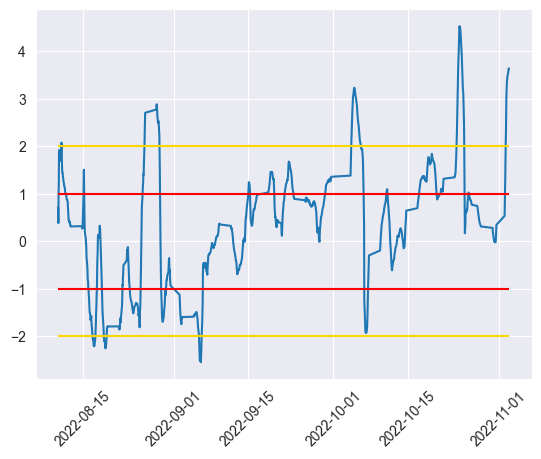

In [30]:
plt.plot(df.index, df["zscore"])
plt.hlines(
    [z_entry_threshold, -z_entry_threshold, z_exit_threshold, -z_exit_threshold],
    colors=["gold", "gold", "red", "red"],
    xmin=df.index[0],
    xmax=df.index[-1],
)
plt.xticks(rotation=45)
plt.show()

# Portfolio Returns

In [31]:
# pf: portfolio
df_pf = pd.DataFrame(index=df.index)

df_pf["positions"] = df["long_market"] - df["short_market"]

df_pf["S1"] = -1.0 * df["S1"] * df_pf["positions"]
df_pf["S2"] = df["S2"] * df_pf["positions"]

df_pf["total"] = df_pf["S1"] + df_pf["S2"]

In [32]:
# df_pf[df_pf["returns"] == -1.0]  # explore

In [33]:
# Calculate simple percentage returns
df_pf["returns"] = df_pf["total"].pct_change()

df_pf["returns"].fillna(0.0, inplace=True)
df_pf["returns"].replace([np.inf, -np.inf], 0.0, inplace=True)
df_pf["returns"].replace(-1.0, 0.0, inplace=True)

# Accumulate returns across each time period
df_pf["returns"] = (1.0 + df_pf["returns"]).cumprod()


df_pf[f"returns_S1"] = (df["S1"].pct_change()+1.0).cumprod()
df_pf[f"returns_S2"] = (df["S2"].pct_change()+1.0).cumprod()


df_pf.tail()

,positions,S1,S2,total,returns,returns_S1,returns_S2
2022-11-02 19:00:00-04:00,-1.0,95.290001,-88.980003,6.309998,0.955312,0.989923,0.982553
2022-11-02 20:00:00-04:00,-1.0,95.309998,-89.040001,6.269997,0.949256,0.990131,0.983216
2022-11-02 21:00:00-04:00,-1.0,95.690002,-89.370003,6.320000,0.956827,0.994079,0.986860
2022-11-02 22:00:00-04:00,-1.0,95.849998,-89.510002,6.339996,0.959854,0.995741,0.988406
2022-11-02 23:00:00-04:00,-1.0,95.800003,-89.529999,6.270004,0.949258,0.995221,0.988626


<AxesSubplot: >

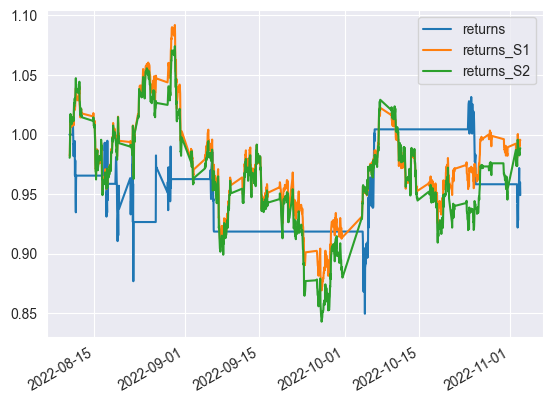

In [34]:
df_pf[["returns", f"returns_S1", f"returns_S2"]].plot()

In [35]:
df_pf["returns"].describe()

count    1201.000000
mean        0.954173
std         0.035592
min         0.849642
25%         0.918622
50%         0.958341
75%         0.994565
max         1.031605
Name: returns, dtype: float64